<a href="https://colab.research.google.com/github/OscarTMa/bitcoin-time-series-analysis/blob/main/notebooks/bitcoin_time_series_analysis_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# List of CSV files
files = [
    'BTC-2018min.csv',
    'BTC-2019min.csv',
    'BTC-2020min.csv',
    'BTC-2021min.csv',
    'BTC-Daily.csv',
    'BTC-Hourly.csv'
]

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("prasoonkottarathil/btcinusd")

print("Path to dataset files:", path)

100%|██████████| 80.2M/80.2M [00:00<00:00, 115MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/prasoonkottarathil/btcinusd/versions/4


In [15]:
# Load and unify all datasets
dfs = []
for file in files:
    # Corrected file path concatenation
    df = pd.read_csv(path + '/' + file)
    # Convert 'Date' column to datetime and sort by date
    df['Date'] = pd.to_datetime(df['date'])
    dfs.append(df)

# Concatenate all datasets
btc_data = pd.concat(dfs)

In [17]:
# Check the column names
print(df.columns)

Index(['unix', 'date', 'symbol', 'open', 'high', 'low', 'close', 'Volume BTC',
       'Volume USD', 'Date'],
      dtype='object')


In [16]:
# Display the first few rows
df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD,Date
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43312.27,52.056320,2.254677e+06,2022-03-01 00:00:00
1,1646089200,2022-02-28 23:00:00,BTC/USD,43085.30,43364.81,42892.37,43178.98,106.816103,4.612210e+06,2022-02-28 23:00:00
2,1646085600,2022-02-28 22:00:00,BTC/USD,41657.23,44256.08,41650.29,42907.32,527.540571,2.263535e+07,2022-02-28 22:00:00
3,1646082000,2022-02-28 21:00:00,BTC/USD,41917.09,41917.09,41542.60,41659.53,69.751680,2.905822e+06,2022-02-28 21:00:00
4,1646078400,2022-02-28 20:00:00,BTC/USD,41361.99,41971.00,41284.11,41914.97,247.151654,1.035935e+07,2022-02-28 20:00:00


# About the dataset columns
"""
Columns:
1. Unix Timestamp - Epoch time, not used directly since we have the 'Date' column.
2. Date - The timestamp in UTC, used as the primary time reference.
3. Symbol - Cryptocurrency pair, filtered for BTC/USDT if necessary.
4. Open - Opening price.
5. High - Highest price.
6. Low - Lowest price.
7. Close - Closing price, used as the main variable for analysis and forecasting.
8. Volume (Crypto) - Volume transacted in BTC.
9. Volume Base Ccy - Volume in the base currency (e.g., USDT).
"""

In [18]:
# Drop duplicates and reset index
btc_data = btc_data.drop_duplicates().reset_index(drop=True)

In [19]:
# Sort by date
btc_data = btc_data.sort_values(by='Date')

In [20]:
# Check for missing values
print("\nMissing values in the combined dataset:")
print(btc_data.isnull().sum())


Missing values in the combined dataset:
unix          0
date          0
symbol        0
open          0
high          0
low           0
close         0
Volume BTC    0
Volume USD    0
Date          0
dtype: int64


In [21]:
# Handle missing values (e.g., forward fill)
btc_data.fillna(method='ffill', inplace=True)

<ipython-input-21-b686da556c5e>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  btc_data.fillna(method='ffill', inplace=True)


In [22]:
# Drop columns that won't be used (e.g., 'Symbol' if all are BTC/USDT)
if 'Symbol' in btc_data.columns:
    btc_data.drop(columns=['Symbol'], inplace=True)

In [23]:
# Set 'Date' as the index for time series analysis
btc_data.set_index('Date', inplace=True)

In [24]:
# Display basic information
print("\nCombined dataset info:")
print(btc_data.info())


Combined dataset info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2185606 entries, 2014-11-28 00:00:00 to 2022-03-01 03:43:00
Data columns (total 9 columns):
 #   Column      Dtype  
---  ------      -----  
 0   unix        int64  
 1   date        object 
 2   symbol      object 
 3   open        float64
 4   high        float64
 5   low         float64
 6   close       float64
 7   Volume BTC  float64
 8   Volume USD  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 166.7+ MB
None


In [25]:
# Save the combined dataset for future use
btc_data.to_csv('BTC-Combined.csv', index=True)

# EDA y Feature Engineering


Statistical summary of the combined dataset:
               unix          open          high           low         close  \
count  2.185606e+06  2.185606e+06  2.185606e+06  2.185606e+06  2.185606e+06   
mean   1.579982e+09  1.921261e+04  1.922602e+04  1.919875e+04  1.921269e+04   
std    3.812484e+07  1.812325e+04  1.813530e+04  1.811077e+04  1.812344e+04   
min    1.417133e+09  1.620000e+02  2.128400e+02  1.524000e+02  1.620000e+02   
25%    1.547113e+09  7.130823e+03  7.135880e+03  7.126003e+03  7.131000e+03   
50%    1.579338e+09  9.528760e+03  9.534775e+03  9.522670e+03  9.528785e+03   
75%    1.613881e+09  3.456179e+04  3.459324e+04  3.452849e+04  3.456168e+04   
max    1.646106e+09  6.900000e+04  6.900000e+04  6.879999e+04  6.900000e+04   

         Volume BTC    Volume USD  
count  2.185606e+06  2.185606e+06  
mean   4.067396e+04  1.958029e+05  
std    1.759215e+06  4.408369e+06  
min    0.000000e+00  0.000000e+00  
25%    2.472077e-01  2.753820e+03  
50%    1.363878e+00  1.697

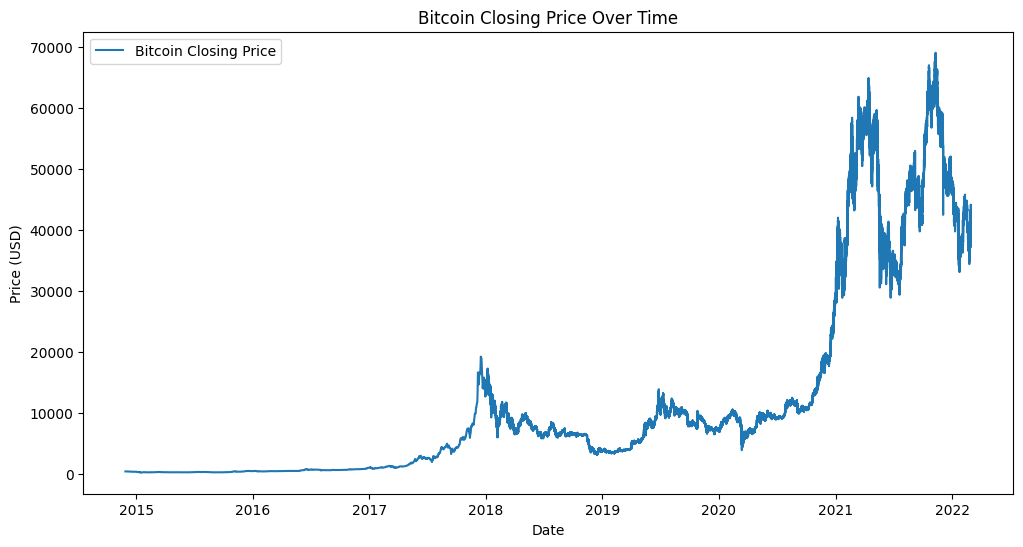

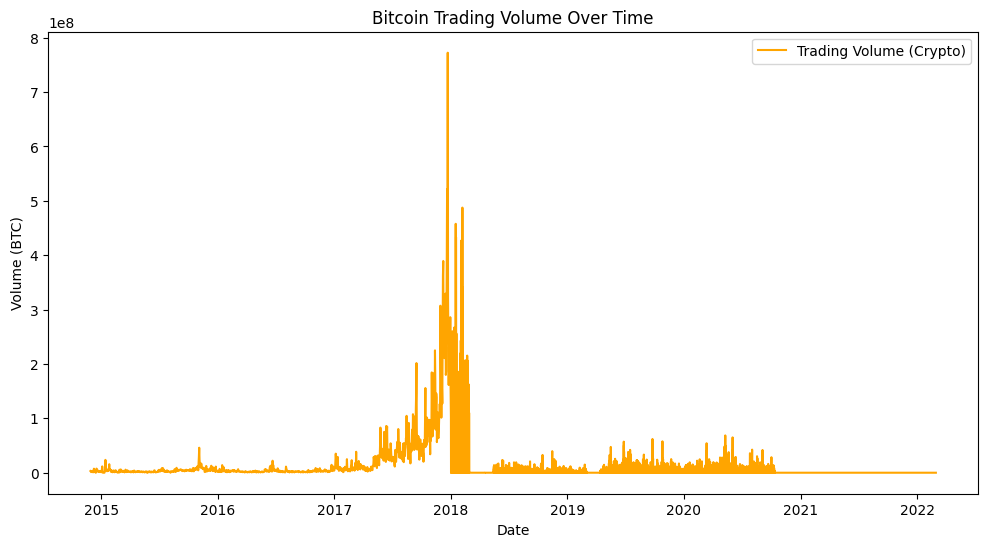

In [27]:
# Exploratory Data Analysis (EDA)

# Statistical summary
print("\nStatistical summary of the combined dataset:")
print(btc_data.describe())

# Plot closing price over time
plt.figure(figsize=(12, 6))
plt.plot(btc_data.index, btc_data['close'], label='Bitcoin Closing Price')
plt.title('Bitcoin Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Plot trading volume
plt.figure(figsize=(12, 6))
plt.plot(btc_data.index, btc_data['Volume BTC'], label='Trading Volume (Crypto)', color='orange')
plt.title('Bitcoin Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume (BTC)')
plt.legend()
plt.show()


In [28]:
# Feature Engineering
# Daily returns
btc_data['Daily_Return'] = btc_data['close'].pct_change()

In [30]:
# Volatility
btc_data['Volatility'] = (btc_data['high'] - btc_data['low']) / btc_data['open']

In [32]:
# Moving Averages (7-day and 30-day)
btc_data['MA_7'] = btc_data['close'].rolling(window=7).mean()
btc_data['MA_30'] = btc_data['close'].rolling(window=30).mean()

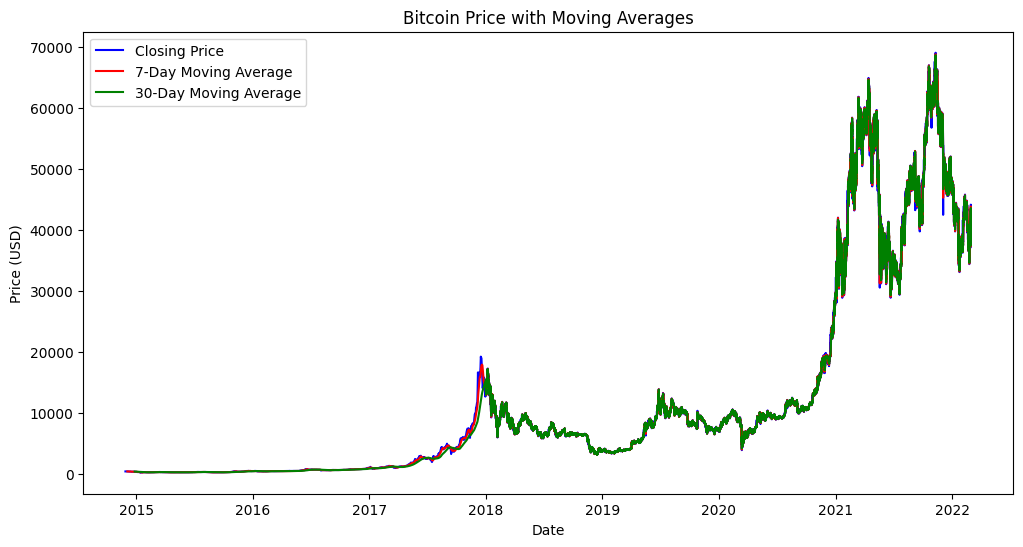

In [34]:
# Plot closing price with moving averages
plt.figure(figsize=(12, 6))
plt.plot(btc_data.index, btc_data['close'], label='Closing Price', color='blue')
plt.plot(btc_data.index, btc_data['MA_7'], label='7-Day Moving Average', color='red')
plt.plot(btc_data.index, btc_data['MA_30'], label='30-Day Moving Average', color='green')
plt.title('Bitcoin Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [35]:
# Display updated dataframe
print("\nDataset with engineered features:")
print(btc_data.head())


Dataset with engineered features:
                  unix                 date   symbol    open    high     low  \
Date                                                                           
2014-11-28  1417132800  2014-11-28 00:00:00  BTC/USD  363.59  381.34  360.57   
2014-11-29  1417219200  2014-11-29 00:00:00  BTC/USD  376.42  386.60  372.25   
2014-11-30  1417305600  2014-11-30 00:00:00  BTC/USD  376.57  381.99  373.32   
2014-12-01  1417392000  2014-12-01 00:00:00  BTC/USD  376.40  382.31  373.03   
2014-12-02  1417478400  2014-12-02 00:00:00  BTC/USD  378.39  382.86  375.23   

             close  Volume BTC  Volume USD  Daily_Return  Volatility  MA_7  \
Date                                                                         
2014-11-28  376.28  3220878.18     8617.15           NaN    0.057125   NaN   
2014-11-29  376.72  2746157.05     7245.19      0.001169    0.038122   NaN   
2014-11-30  373.34  1145566.61     3046.33     -0.008972    0.023024   NaN   
2014-12-01  37